# Chemistry machine learning for drug discovery with DeepChem

This example uses machine learning to predict the lipophilicty of compounds.

[Lipophilicty](https://en.wikipedia.org/wiki/Lipophilicity) measures how well a compound dissolves in non-polar media such as fats and lipids. So it's important for drugs that are delivered orally (for example, via a pill) because the active ingredient [needs to be absorbed into the lipids](https://emerypharma.com/blog/drug-lipophilicity-and-absorption-a-continuous-challenge-toward-the-goal-of-drug-discovery/) of biological membranes.

In [53]:
%%capture
!pip install --pre deepchem[tensorflow]

In [54]:
import deepchem as dc
import seaborn
import pandas as pd
import matplotlib.pyplot as plt

[DeepChem](https://deepchem.io/) is a free and open-source Python package for deep learning for chemistry and other sciences. DeepChem has a [lipophilicty data set](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets) contains measured [logD](https://www.cambridgemedchemconsulting.com/resources/physiochem/logD.html) values for 4200 compounds.

As usual for machine learning (ML), we split the data set into training and test data. We train the ML model on the train data, then apply it to the test data and check how well the model predicts the lipophilicty of compounds that the model hasn't processed before.

For this data set, we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter) the 4200 compounds based on the [Bemis-Murcko scaffold representation](https://pubs.acs.org/doi/10.1021/jm9602928). Such splitting groups molecules based on their scaffolds (core structure) to [prevent train and test from having very similar molecules](httphttps://github.com/deepchem/deepchem/blob/master/examples/tutorials/Working_With_Splitters.ipynb), which could lead to the model appearing to perform well on the test set, but then performing poorly on less-similar molecules in production.

In [55]:
tasks, datasets, transformers = dc.molnet.load_lipo(featurizer='GraphConv', splitter='Scaffold')
train_dataset, valid_dataset, test_dataset = datasets

The number of compounds in the train, validate, and test sets is:

In [56]:
splits = (train_dataset.X.shape[0], valid_dataset.X.shape[0], test_dataset.X.shape[0])
splits

(3360, 420, 420)

Which represents an 80:10:10 train:validate:test split:

In [57]:
[split / sum(splits) for split in splits]

[0.8, 0.1, 0.1]

Next, we build a model using DeepChem's [graph convolutional network](https://deepchem.readthedocs.io/en/latest/api_reference/models.html). We use the [dropout technique](https://ai-pool.com/a/s/dropout-in-deep-learning) to avoid overfitting.

In [58]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

Then we train the model on the train dataset.

In [59]:
model.fit(train_dataset, nb_epoch=100)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_14:0", shape=(438,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_13:0", shape=(438, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_17:0", shape=(3024,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_16:0", shape=(3024, 64), dtype=float32

0.22611637115478517

To check how well the model fits the train and test data, we examine the [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score.

In [60]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.8325585834721163}
Test set score: {'pearson_r2_score': 0.5112899170144258}


The [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score is worse for the test data than for the train data. This is expected because the test data is new to the model.

One contributing factor might be that our train set may not have molecules similar enough to those in the test set. Recall that we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter), so it's possible that such splitting led to compounds in the test set that have scaffolds significantly different from those in the train set.

Adding compounds to the dataset so that there is less "scaffold distance" (difference in scaffold structure) between groups of compounds might help. To take a simple hypothetical example, if we had a dataset with compounds containing fused rings, with many two-ring compounds and few four-ring compounds, scaffold splitting might put all the two-ring compounds in the train set and all the four-ring compounds in the test set. We expect that would lead to poor predictions on the test set. We would want to augment the dataset by adding compounds containing three fused rings.

To learn more about how well the model works, let's apply it to the test data and compare the predicted and experimental results.

In [61]:
lipos = model.predict_on_batch(test_dataset.X)

Then we make put the measured and model-predicted results into a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for easy processing.

In [62]:
lipo_list = []
expt_lipo_list = []
for molecule, lipo, test_lipo in zip(test_dataset.ids, lipos, test_dataset.y):
    lipo_list += [lipo[0]]
    expt_lipo_list += [test_lipo[0]]
    
df = pd.DataFrame(list(zip(expt_lipo_list, lipo_list)), columns = ["measured", "predicted"])
df

,measured,predicted
0,-1.810832,-0.254384
1,0.319651,-0.215557
2,-0.192325,0.021240
3,0.938978,1.049665
4,0.856401,0.019757
...,...,...
415,0.815112,1.072650
416,1.327089,0.066548
417,-0.175810,0.284551
418,0.071921,-0.441130


Now we can use a scatter plot to compare the predicted against measured values. We use the [seaborn statistical data visualization package](https://seaborn.pydata.org/) to plot the data. We show the line where the predicted and measured lipophilicty values are equal, in other words the line that all points would lie on if the model made perfect predictions.

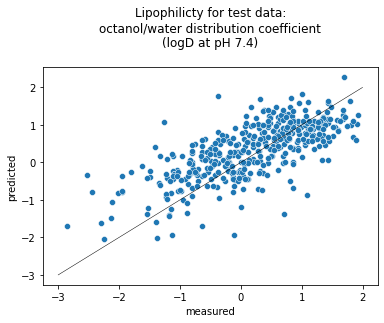

In [75]:
seaborn.scatterplot(data=df, x = "measured", y = "predicted").set(title='Lipophilicty for test data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n');
equal_line_x = [-3, 2]
equal_line_y = equal_line_x
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

Let's plot the train data set to visually compare those two sets. We made the markers (points) smaller because there are so many and we don't want them to overlap with each other so much.

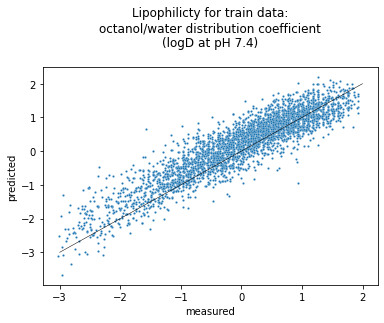

In [76]:
lipos_train = model.predict_on_batch(train_dataset.X)
lipo_list_train = []
expt_lipo_list_train = []
for molecule, lipo, test_lipo in zip(train_dataset.ids, lipos_train, train_dataset.y):
    lipo_list_train += [lipo[0]]
    expt_lipo_list_train += [test_lipo[0]]
df_train = pd.DataFrame(list(zip(expt_lipo_list_train, lipo_list_train)), columns = ["measured", "predicted"])
seaborn.scatterplot(data=df_train, x = "measured", y = "predicted", s=5).set(title='Lipophilicty for train data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n');
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

To overlay the two plots, we'll first [concatenate the data](https://stackoverflow.com/questions/51732867/seaborn-plot-two-data-sets-on-the-same-scatter-plot#51733133) in the two sets (test and train), adding a `dataset` column to keep track of which set each point came from.

In [65]:
concatenated = pd.concat([df.assign(dataset='test'), df_train.assign(dataset='train')])

In [66]:
concatenated

,measured,predicted,dataset
0,-1.810832,-0.254384,test
1,0.319651,-0.215557,test
2,-0.192325,0.021240,test
3,0.938978,1.049665,test
4,0.856401,0.019757,test
...,...,...,...
3355,0.526093,0.651797,train
3356,-0.027172,0.519434,train
3357,-1.629163,-0.853340,train
3358,0.633443,0.845679,train


Now we can plot the two datasets on one graph.

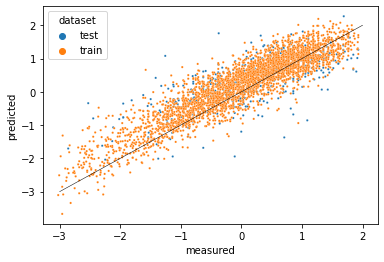

In [74]:
seaborn.scatterplot(x='measured', 
                    y='predicted', 
                    data=concatenated,
                    hue='dataset',
                    s=5);
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

Some of the test (blue) data points are predicted (on the vertical axis) outliers, reflecting that the model performs poorly for them. We might consider featurizing our data further to let the model predict lipophilicity based on more properties of the compounds. Above, we used the [`GraphConv`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#graph-convolution-featurizers) featurizer, which represents only the atoms in a molecule. We might try the [`WeaveFeaturizer`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#weavefeaturizer) which also represents the bonds, though it requires more resources because it stores the relationship between each pair of atoms in a molecule.

This blog post was based on the DeepChem tutorial [The Basic Tools of the Deep Life Sciences](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/The_Basic_Tools_of_the_Deep_Life_Sciences.ipynb).